In [1]:
# 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
Train_data = pd.read_csv('./data/used_car_train_20200313.csv', sep=' ')
TestA_data = pd.read_csv('./data/used_car_testA_20200313.csv', sep=' ')

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestA_data.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


In [5]:
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)

categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')
Index(['notRepairedDamage'], dtype='object')


In [6]:
## 选择特征列
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','creatDate','price','model','brand','regionCode','seller']]
feature_cols = [col for col in feature_cols if 'Type' not in col]

## 提前特征列，标签列构造训练样本和测试样本
X_data = Train_data[feature_cols]
Y_data = Train_data['price']

X_test  = TestA_data[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (150000, 18)
X test shape: (50000, 18)


In [8]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

In [9]:
print('Sta of label:')
Sta_inf(Y_data)

Sta of label:
_min 11
_max: 99999
_mean 5923.327333333334
_ptp 99988
_std 7501.973469876635
_var 56279605.942732885


In [10]:
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [11]:
## xgb-Model
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

[13:11:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train mae: 621.8412587378155
Val mae 714.2722671070576


In [12]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

In [13]:
from sklearn.ensemble import RandomForestRegressor
def buil_model_RFR(x_train,y_train):
    model = RandomForestRegressor()
    model.fit(x_train,y_train)
    return model

In [15]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

# print('Train lgb...')
# model_lgb = build_model_lgb(x_train,y_train)
# val_lgb = model_lgb.predict(x_val)
# MAE_lgb = mean_absolute_error(y_val,val_lgb)
# print('MAE of val with lgb:',MAE_lgb)

# print('Predict lgb...')
# model_lgb_pre = build_model_lgb(X_data,Y_data)
# subA_lgb = model_lgb_pre.predict(X_test)
# print('Sta of Predict lgb:')
# Sta_inf(subA_lgb)

print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

# print('Predict xgb...')
# model_xgb_pre = build_model_xgb(X_data,Y_data)
# subA_xgb = model_xgb_pre.predict(X_test)
# print('Sta of Predict xgb:')
# Sta_inf(subA_xgb)


print('Train RFR...')
model_rfr = buil_model_RFR(x_train,y_train)
val_rfr = model_rfr.predict(x_val)
MAE_rfr = mean_absolute_error(y_val,val_rfr)
print('MAE of val with xgb:',MAE_rfr)

Train xgb...
[13:20:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of val with xgb: 713.0454681648307
Train RFR...
MAE of val with xgb: 675.818100118344


In [ ]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_rfr/(MAE_xgb+MAE_rfr))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_rfr))*val_xgb
val_Weighted[val_Weighted<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

In [15]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

MAE of val with Weighted ensemble: 689.2464457647812


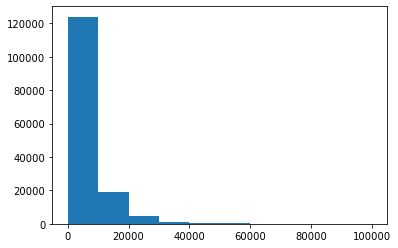

In [16]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

## 查看预测值的统计进行
plt.hist(Y_data)
plt.show()
plt.close()

In [17]:
sub = pd.DataFrame()
sub['SaleID'] = TestA_data.SaleID
sub['price'] = sub_Weighted
sub.to_csv('./sub_Weighted.csv',index=False)

In [18]:
sub.head()

,SaleID,price
0,150000,39616.196248
1,150001,379.865451
2,150002,7706.025804
3,150003,11936.973051
4,150004,576.336617
